In [12]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import math
import json
from scipy.optimize import curve_fit
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
warnings.filterwarnings('ignore', message='Converting to PeriodArray/Index representation will drop timezone information.')
stop_words = set(stopwords.words('english'))


#dfStargazers = pd.read_csv("../inputs/huggingface-transformers.csv")
f = "../outputs/data"
dirs = os.listdir(f)

In [31]:
print(len(dirs))

873


0


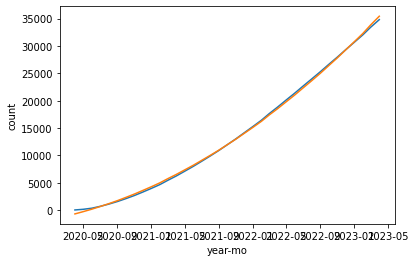

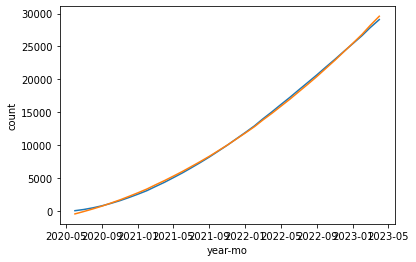

1


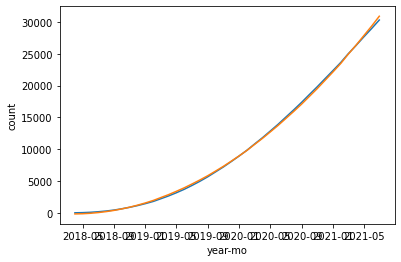

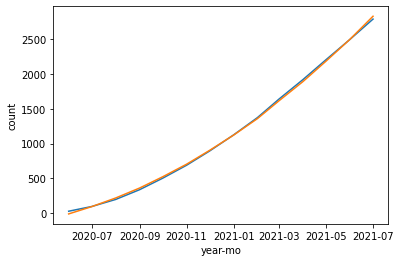

2


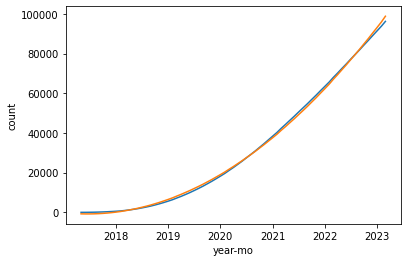

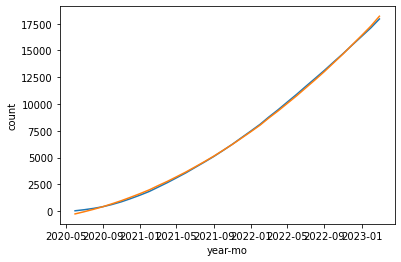

3


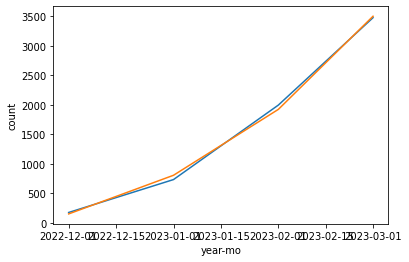

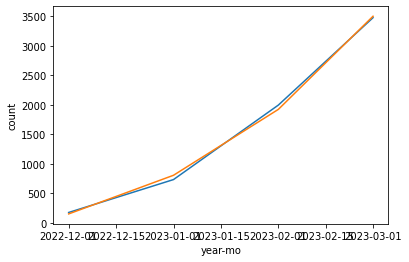

4


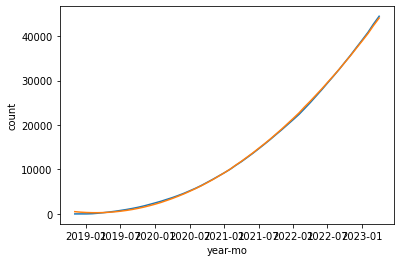

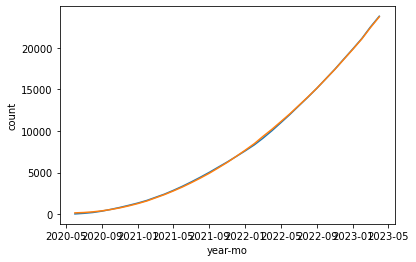

5


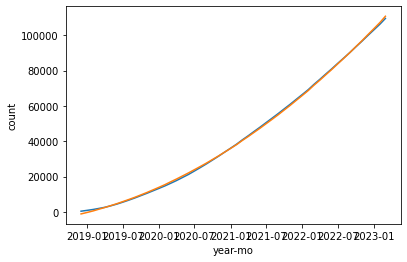

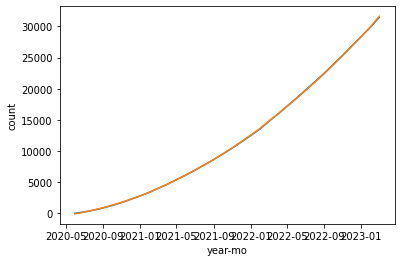

6


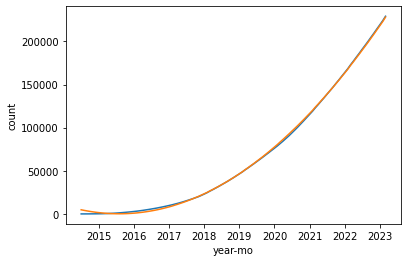

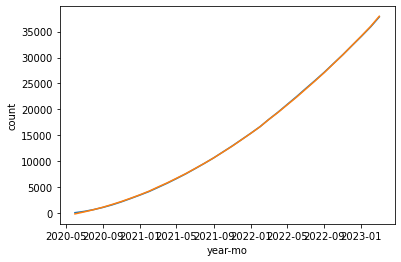

7


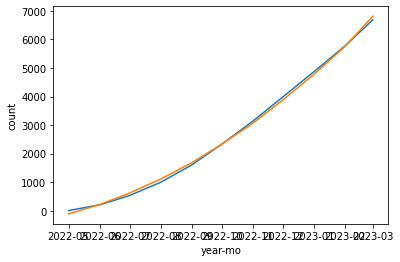

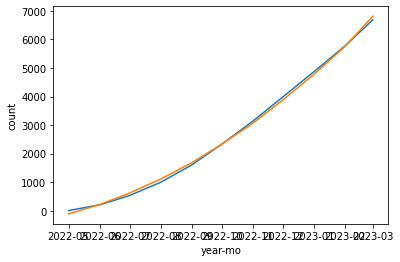

8


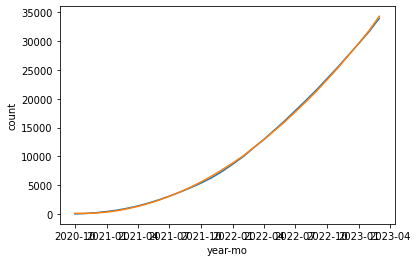

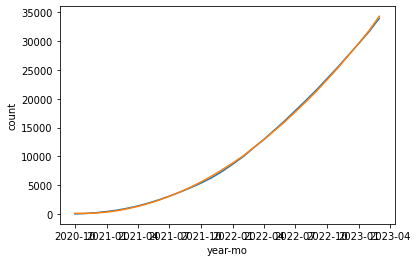

9


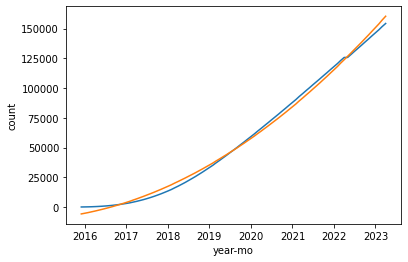

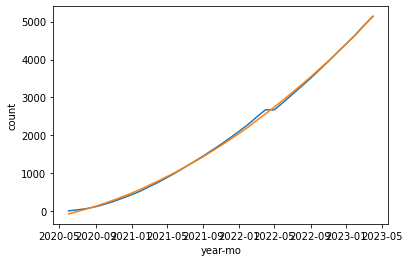

In [34]:
class EDA():
    def __init__(self):
        self.outputDir = "../outputs/data"
        self.keywords = [
            "nlp",
            "natural language processing",
            "ai",
            "chat-gpt",
            "image",
            "llm",
            "python"
        ]
    def getReadMe(self,path):
        with open(f"{path}/README.md", "r") as file:
            readme = file.read().lower()
        return readme
    
    def parseReadMe(self, path):
        readme = self.getReadMe(path)
        keyword_counts = {keyword:readme.count(keyword) for keyword in self.keywords}
        return keyword_counts
    
    def getCumData(self, df):
        df.loc[:, "created_at"] = df["created_at"].dt.to_period('M')
        data = df.groupby("created_at")["id"].count().reset_index()
        data = data.rename(columns={"created_at":"year-mo"})
        data["year-mo"] = data["year-mo"].dt.to_timestamp()
        data["count"] = data.id.cumsum()
        return data
    
    def graphForksOverTime(self, forksCum):
        coefs, y_fit = self.getCurveFit(forksCum)
        #data = self.getCumData(df)
        forksCum["year-mo"] = forksCum["year-mo"].astype("datetime64[M]")
        sns.lineplot(data=forksCum, x="year-mo", y="count")
        plt.plot(forksCum["year-mo"],y_fit)
        plt.show()
    
    def readGithubInfo(self,path):
        with open(f"{path}/info.json", 'r') as f:
            data = json.load(f)
        return data
    
    def getForksAfterDate(self,df):
        cutoff_date = pd.Timestamp("2020-06-11", tz='UTC')
        forks_after_date = df[df["created_at"] >= cutoff_date]
        return forks_after_date
    
    def getPercentChange(self, df):
        counts = list(df["count"])
        percent_change = [counts[i]/counts[i-1] for i,x in list(enumerate(counts))[1:]]
        percent_change = [np.nan] + percent_change
        df["Percent Change"] = percent_change
        return df.loc[:,["year-mo","Percent Change"]]
    
    
    def getForksData(self,path):
        df = pd.read_csv(path+"/forks.csv", low_memory=False)
        df = df.sort_values("created_at")
        df['created_at'] = pd.to_datetime(df['created_at'])
        return df
    
    def curve_func(self,x, a, b,c):
        return a * x + b*x**2 + c
    
    def getCurveFit(self, df):
        x = df.index.values
        y = df['count']
        coefs, _ = curve_fit(self.curve_func, x, y)
        y_fit = self.curve_func(x, *coefs)
        residuals = y - y_fit
        res = np.sum(residuals**2)
        tot = np.sum((y - np.mean(y))**2)
        r_squared = 1 - (res / tot)
        #print('R-squared:', r_squared)
        return coefs, y_fit
    
#     def getCurveFit(self,df):
#         x = df.index.values
#         y = df['count']
#         print(np.polyfit(np.log(x), y, 1))
        
    def getCumData(self, df):
        data = df.assign(created_at=df["created_at"].dt.to_period('M'))
        data = data.groupby("created_at")["id"].count().reset_index().rename(columns={"created_at":"year-mo"})
        data = data.assign(year_mo=lambda x: x["year-mo"].dt.to_timestamp(), count=lambda x: x["id"].cumsum())
        # Create a new DataFrame with all the possible year-month combinations
        start_date = data["year-mo"].min()
        end_date = data["year-mo"].max()
        all_dates = pd.date_range(start_date.to_timestamp(), end_date.to_timestamp(), freq="MS").to_period("M")
        all_data = pd.DataFrame({"year-mo": all_dates})
        # Merge the original data with the new data to fill in the missing year-month combinations
        data = all_data.merge(data, on="year-mo", how="left")
        data["count"] = data["count"].fillna(0).cumsum()
        return data.loc[:, ["year-mo", "count"]]
        
    def goThroughDirectories(self):
        self.DATA = []
        for i in range(0,len(dirs[:10])):
            print(i)
            if ".DS_Store" in dirs[i]:
                continue
            repo = "/".join(dirs[i].split("*"))
            path = self.outputDir+"/"+dirs[i]
            try:
                forks = self.getForksData(path)
            except pd.errors.ParserError:
                print(repo)
                continue
                
            forksCum = self.getCumData(forks)
            forksPost = self.getForksAfterDate(forks)
            forksPostCum = self.getCumData(forksPost)

            if len(forksPostCum)<=2: 
                continue
        
            info = self.readGithubInfo(path)
            keyword_counts = self.parseReadMe(path)
            
            data = {
                "Repo": repo,
                "index": i,
                "info":info,
                "topics": info["data"]["topics"],
                "readme.md-keyword_counts": keyword_counts,
                "forksTotal":forks,
                "forksTotalCum":forksCum,
                "forksPostCum":forksPostCum,
                "curveFit":  self.getCurveFit(forksPostCum),
                "readMe":self.getReadMe(path),
                "percent_change":self.getPercentChange(forksCum)
            }
            self.DATA.append(data)
            df =  self.getPercentChange(forksCum)
            p = self.getPercentChange(forksCum)["Percent Change"]

            
            self.graphForksOverTime(forksCum)
            self.graphForksOverTime(forksPostCum)

eda = EDA()
eda.goThroughDirectories()

In [ ]:
data = eda.DATA
data

In [29]:
class Model:
    def readMe(self):
        most_common = []
        for repo in eda.DATA:
            readme = repo["readMe"]
            words = readme.split(" ")
            words = [word for word in words if word not in stop_words and len(word)>4 and all(char.isalpha() for char in word)]
            word_counts = Counter(words)
            most_common += word_counts.most_common(3)
        most_common = [w[0] for w in most_common]
        most_common = Counter(most_common).most_common(100)
        most_common = [w[0] for w in most_common]
        self.keywords = set(most_common)
        
    def parseReadMe(self,readme):
        keyword_counts = {keyword:readme.count(keyword) for keyword in self.keywords}
        return keyword_counts
    
    def dataCleaning(self):
        X = []
        y = []
        for repo in eda.DATA:
            readme = repo["readMe"]
            data = self.parseReadMe(readme)
            X.append(data)
            b = repo["curveFit"][0][0]
            y.append(b)
        self.X = pd.DataFrame(X)
        self.y = pd.Series(y)
        self.cov = self.X.corrwith(self.y)
        # Print the correlation matrix
        print(self.cov)
        
    
    
        
    def model(self):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

#         Normalize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        print(np.count_nonzero(np.sign(y_train)==-1))

        # Train the KNN model
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)

        # Predict the test data
        y_pred = knn.predict(X_test)


model = Model()
model.readMe()
model.dataCleaning()
model.model()

apache       0.001238
knowledge    0.008803
mycroft     -0.040858
project     -0.094548
cascaded    -0.042009
               ...   
milvus      -0.085628
audio       -0.042502
arxiv        0.000470
raval       -0.029038
siraj       -0.029038
Length: 100, dtype: float64
7


ValueError: Unknown label type: 'continuous'

In [249]:
max(list(model.cov))

0.11089753798755751

In [101]:
# from sklearn.cluster import KMeans
# from sklearn.feature_extraction.text import TfidfVectorizer
# import pandas as pd

# # Load data
# # data = pd.read_csv('readme_data.csv')

# # Vectorize text data using TF-IDF
# vectorizer = TfidfVectorizer(stop_words='english')
# X = vectorizer.fit_transform(["Hi my name is julia"])
# print(X)

# # Perform k-means clustering
# kmeans = KMeans(n_clusters=3)
# kmeans.fit(X)

# # Print cluster centers and top terms per cluster
# order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
# terms = vectorizer.get_feature_names()
# for i in range(3):
#     print("Cluster %d:" % i)
#     for j in order_centroids[i, :10]:
#         print(" %s" % terms[j])
#     print()


In [108]:
dfForks['created_at'] = pd.to_datetime(dfForks['created_at'])
dfForks["year-mo"] = dfForks["created_at"].dt.to_period('M')
data = dfForks.groupby("year-mo")["id"].count().reset_index()
data["year-mo"] = data["year-mo"].dt.to_timestamp()
data["count"] = data.id.cumsum()
sns.lineplot(data=data, x="year-mo", y="count")
plt.show()

NameError: name 'dfForks' is not defined

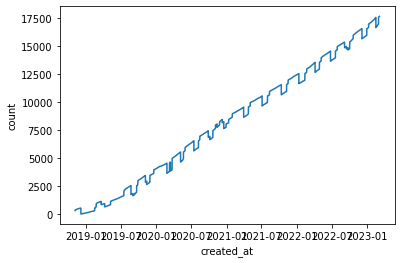

In [38]:
dfForks['created_at'] = pd.to_datetime(dfForks['created_at'])
dfForks["count"] = len(dfForks) - np.array(dfForks.index)
sns.lineplot(data=dfForks, x="created_at", y="count")
plt.show()

In [149]:
df = df.reset_index().rename(columns={"index":"x","count":"y"})

In [154]:
df

,x,year-mo,id,y
0,0,2018-11-01,212,212
1,1,2018-12-01,112,324
2,2,2019-01-01,141,465
3,3,2019-02-01,223,688
4,4,2019-03-01,201,889
5,5,2019-04-01,186,1075
6,6,2019-05-01,217,1292
7,7,2019-06-01,217,1509
8,8,2019-07-01,485,1994
9,9,2019-08-01,316,2310


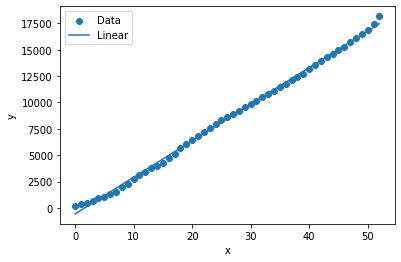

In [159]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt



# Define the functions for the linear and exponential curves
def linear(x, a, b):
    return a * x + b

def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

# Fit the linear curve to the data
popt_linear, pcov_linear = curve_fit(linear, df['x'], df['y'])
a_linear, b_linear = popt_linear

# Fit the exponential curve to the data
popt_exponential, pcov_exponential = curve_fit(exponential, df['x'], df['y'])
a_exponential, b_exponential, c_exponential = popt_exponential

# Create a scatter plot of the data
plt.scatter(df['x'], df['y'], label='Data')

# Plot the linear curve
plt.plot(df['x'], linear(df['x'], a_linear, b_linear), label='Linear')

# Plot the exponential curve
#plt.plot(df['x'], exponential(df['x'], a_exponential, b_exponential, c_exponential), label='Exponential')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Linear R-squared: 0.998030857642197
Exponential R-squared: -213307372.45354235
